In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import numpy as np
import tensorflow as tf
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_circles
from IPython import display
from common import *

In [3]:
def make_grid(n_samples):
    np.random.seed(123)
    grid_x, grid_y = np.meshgrid(np.linspace(0.0, 1.0, 5),
                                 np.linspace(0.0, 1.0, 5))
    centers = np.c_[grid_x.ravel(), grid_y.ravel()]
    x, _ = make_blobs(n_samples=n_samples,
                      cluster_std=np.zeros(25)+0.001,
                      centers=centers)
    # Scale to (0, 1)
    x = (x - x.min())/(x - x.min()).max()
    x = (x - 0.5)*0.35 + 0.5
    return x

In [10]:
from common import attack_config
tf.random.set_random_seed(123)
x_train, y_train = make_dataset(make_grid, n_pos_samples=1000, n_neg_samples=1000)
tf.reset_default_graph()
detector = Model(var_scope='detector', hidden_sizes=[500]*5)
detector_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                  scope='detector')

x_train_others = x_train[y_train == 0]
x_train_target = x_train[y_train == 1]
y_train_others = y_train[y_train == 0]
y_train_target = y_train[y_train == 1]


attack = PGDAttackDetector(detector, **attack_config, batch_size=x_train_others.shape[0])
print(attack_config)

{'max_distance': 0.5, 'num_steps': 10, 'step_size': 0.05, 'random_start': True, 'norm': 'Linf', 'optimizer': 'adam', 'x_min': 0.0, 'x_max': 1.0}


In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [12]:
optimizer = tf.train.AdamOptimizer(5e-4)
train_step = optimizer.minimize(detector.xent)
sess.run(tf.variables_initializer(optimizer.variables()))

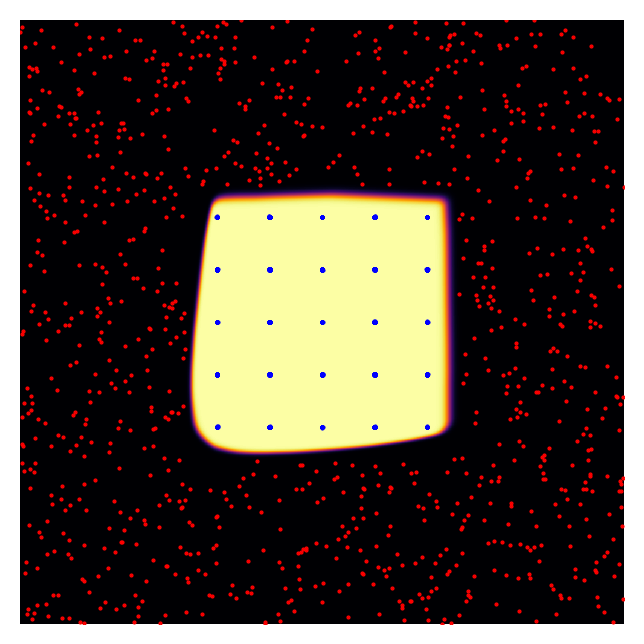

In [13]:
plt.figure(figsize=(4, 4), dpi=200)
ax = plt.subplot(1, 1, 1)
ax.set_axis_off()

for i in range(500):
    sess.run(train_step,feed_dict={detector.x_input: x_train, detector.y_input: y_train})
plot_detector(detector, x_train, y_train, ax, sess)
plt.show()


In [14]:
for i in range(50000):
    x_train_others_adv = attack.perturb(x_train_others, None, sess, verbose=False)
    x_train_with_adv = np.concatenate([x_train_target, x_train_others_adv])
    y_train_with_adv = np.concatenate([y_train_target, y_train_others])
    sess.run(train_step,feed_dict={detector.x_input: x_train_with_adv, detector.y_input: y_train_with_adv})

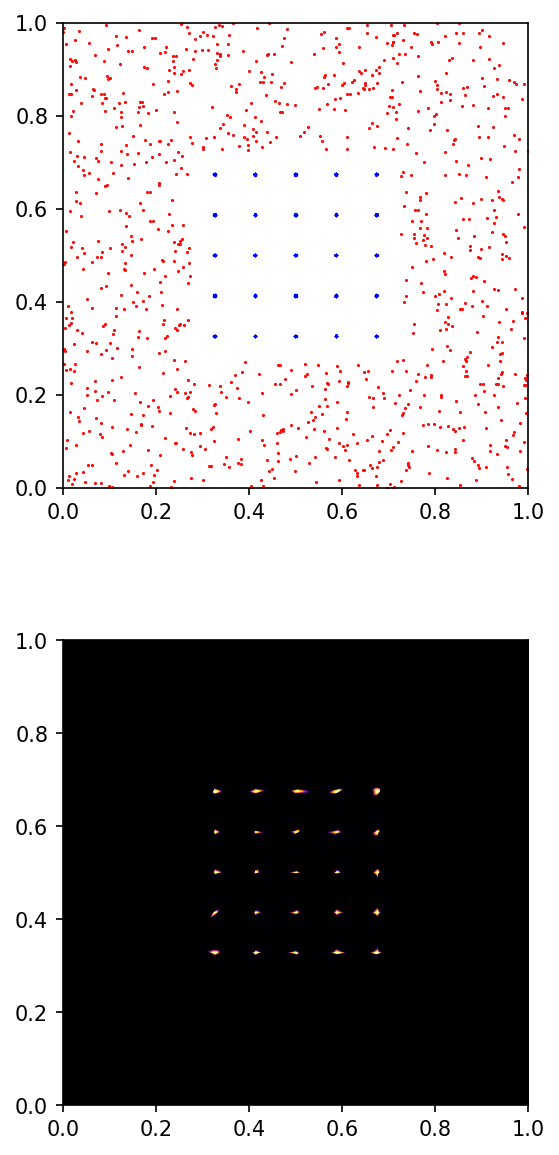

In [15]:
fig, (ax0, ax1) = plt.subplots(nrows=2, figsize=(4, 10), dpi=150)
plot_detector(detector, x_train, y_train, ax0, sess, plot_z=False)
plot_detector(detector, x=None, y=None, ax=ax1, sess=sess)
plt.show()